In [1]:
import numpy as np
import pandas as pd
from Bio import SeqIO
import Bio.SeqUtils.MeltingTemp as mt

from dredFISH.Utils.__init__plots import *

In [2]:
def parse_encoding(seq, option='+'):
    # P1-R-a-E-a-R-a-R-P2
    breakpoints = np.array([0, 20, 40, 41, 71, 72, 92, 93, 113, 133])
    if option == '+': # 1R-2R
        bp = breakpoints
        
        p1 = seq[bp[0]:bp[1]]
        R1 = seq[bp[1]:bp[2]]
        s1 = seq[bp[2]:bp[3]]
        E  = seq[bp[3]:bp[4]]
        s2 = seq[bp[4]:bp[5]]
        R2 = seq[bp[5]:bp[6]]
        s3 = seq[bp[6]:bp[7]]
        R3 = seq[bp[7]:bp[8]]
        p2 = seq[bp[8]:bp[9]]
        
        return E, R1, R2, R3, p1, p2, s1, s2, s3,  
        
    if option == '-': # 2R-1R
        bp = (133 - breakpoints)[::-1]
    
        p1 = seq[bp[0]:bp[1]]
        R1 = seq[bp[1]:bp[2]]
        s1 = seq[bp[2]:bp[3]]
        R2 = seq[bp[3]:bp[4]]
        s2 = seq[bp[4]:bp[5]]
        E  = seq[bp[5]:bp[6]]
        s3 = seq[bp[6]:bp[7]]
        R3 = seq[bp[7]:bp[8]]
        p2 = seq[bp[8]:bp[9]]
        
        return E, R1, R2, R3, p1, p2, s1, s2, s3,  

In [3]:
def recalc_tm(seq, fmd=0, Na=1e-5, dnac1=0, dnac2=0):
    """
    """
    res = mt.Tm_NN(seq, Na=Na, dnac1=dnac1, dnac2=dnac2)
    res = mt.chem_correction(res, fmd=fmd)
    return res
    
def get_gc(seq):
    """
    """
    return (seq.count('G') + seq.count('C'))/len(seq)

In [4]:
f = "/bigstore/binfo/Probe_Sets/dredFISH_Final_Oligos.fasta"
resall = []
encseqs = []
for i, record in enumerate(SeqIO.parse(f, "fasta")):
    seq = record.seq
    dsp = record.description
    
    if dsp.split(' ')[4].startswith('RS'):
        option = '-' # R[R]ER
    else:
        option = '+' # R[E]RR
        
    E, R1,R2,R3, p1,p2, s1,s2,s3 = parse_encoding(seq, option=option)
    if (str(s1),str(s2),str(s3)) == ('A', 'A', 'A'):
        pass
    else:
        print(s1,s2,s3)
        break
    assert R1 == R2
    assert R1 == R3
    
    # resall.append(res)
    encseqs.append(str(E))
    
    # if i > 100:
    #     break

In [5]:
dfviz = pd.DataFrame()
dfviz['seq'] = encseqs
dfviz

,seq
0,GGTCTTCATGGTGCATGTGGTTCATCACCA
1,AGGGTCTTCTAGATGCACCTGAAGCTGGTT
2,ATGACTGATCTCTCTGGCTCCCCTGGGAGC
3,GCAAACTTCTGTCTCCTCCAATAACACAGC
4,TGAGAAGAGTATCTCAGTGGCTGACTAAGC
...,...
89956,GGAGTTCAAGCTCTGTCCAGCTTCATTCGT
89957,GGGACTCACAGAGAGGCTCTGCAGACCAAT
89958,GGAACAGAATAAAACAAAAGGTCTCCCTCC
89959,CAGCACGTACTGTGCTTGGGGCATGGCTTG


In [6]:
dfviz['dfttm'] = dfviz['seq'].apply(lambda x: recalc_tm(x, fmd=50, Na=390, dnac1=25, dnac2=25))
dfviz['ourtm'] = dfviz['seq'].apply(lambda x: recalc_tm(x, fmd=30, Na=300, dnac1=2,  dnac2=0.001))
dfviz['mattm'] = dfviz['seq'].apply(lambda x: recalc_tm(x, fmd=0,  Na=300, dnac1=2,  dnac2=2)) 

Text(0, 0.5, 'TM')

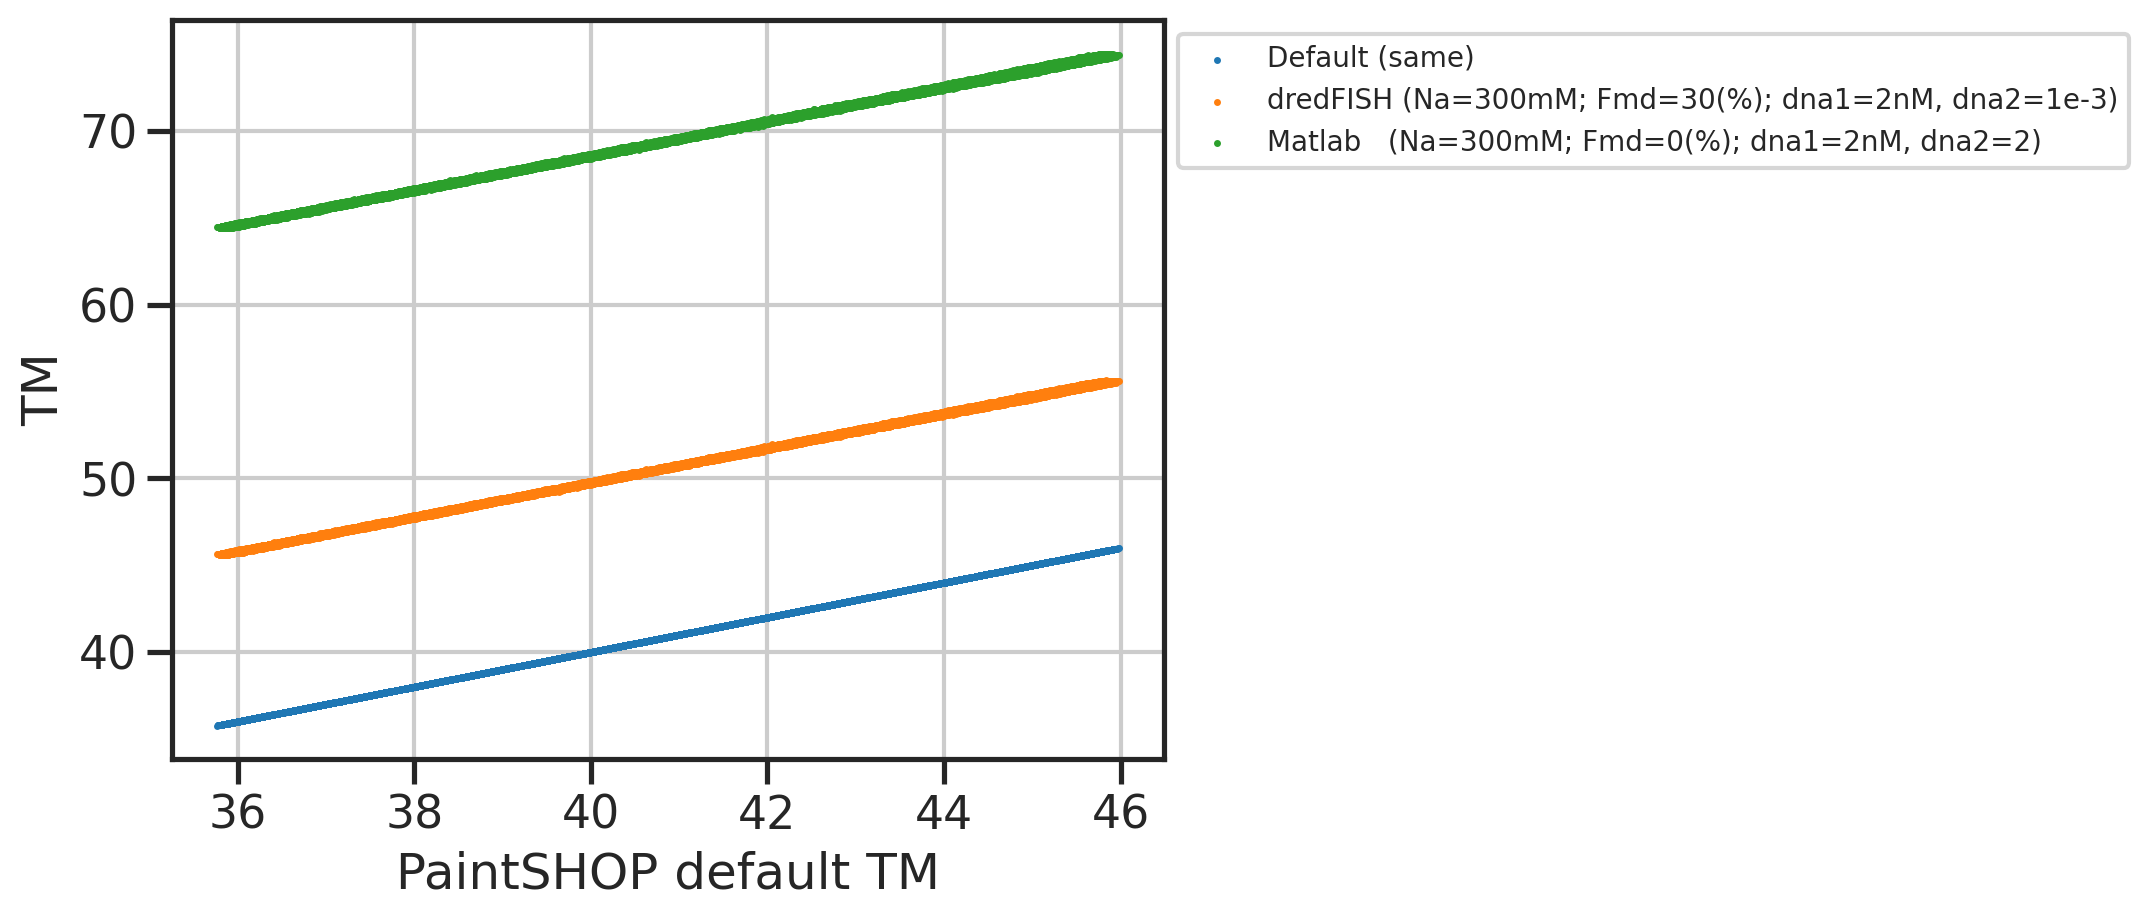

In [7]:
plt.scatter(dfviz['dfttm'].values, 
            dfviz['dfttm'].values,
            s=1,
            label="Default (same)",
            ) 
plt.scatter(dfviz['dfttm'].values, 
            dfviz['ourtm'].values,
            s=1,
            label="dredFISH (Na=300mM; Fmd=30(%); dna1=2nM, dna2=1e-3)",
            ) 
plt.scatter(dfviz['dfttm'].values, 
            dfviz['mattm'].values,
            s=1,
            label="Matlab   (Na=300mM; Fmd=0(%); dna1=2nM, dna2=2)",
            ) 
# plt.plot([43,46], [43,46], '--k', label='y=x')
# plt.xticks([37, 40, 45, 50, 52])
plt.legend(bbox_to_anchor=(1,1), fontsize=10)
plt.xlabel("PaintSHOP default TM")
plt.ylabel("TM")

Text(0, 0.5, 'TM')

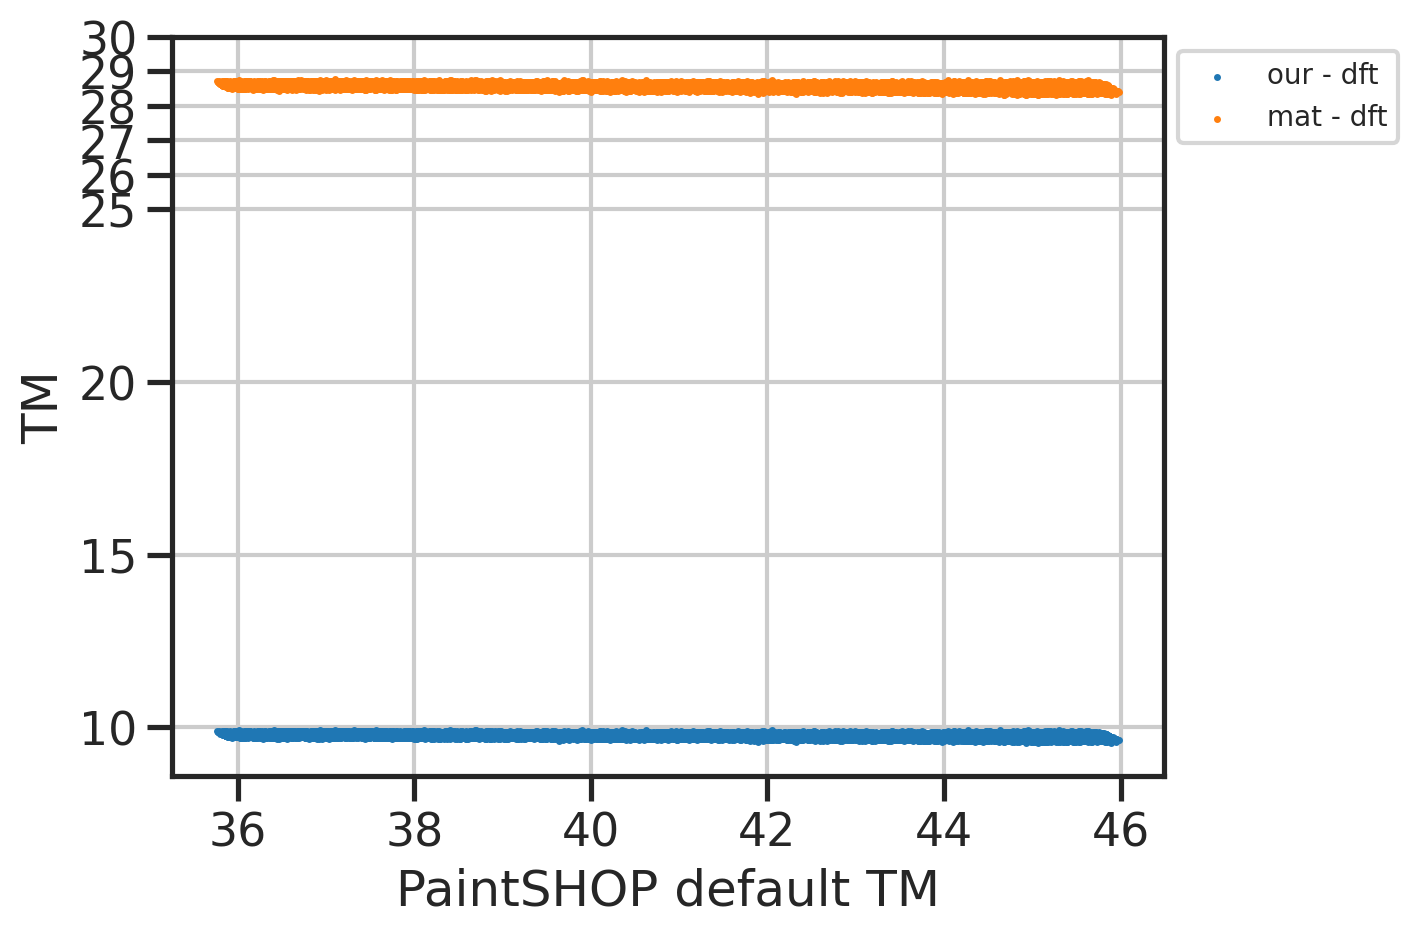

In [16]:
plt.scatter(dfviz['dfttm'].values, 
            dfviz['ourtm'].values - dfviz['dfttm'].values,
            s=1,
            label="our - dft",
            ) 
plt.scatter(dfviz['dfttm'].values, 
            dfviz['mattm'].values - dfviz['dfttm'].values,
            s=1,
            label="mat - dft",
            ) 
# plt.plot([43,46], [43,46], '--k', label='y=x')
# plt.xticks([37, 40, 45, 50, 52])
plt.yticks([10,15,20,25,26,27,28,29,30])
plt.legend(bbox_to_anchor=(1,1), fontsize=10)
plt.xlabel("PaintSHOP default TM")
plt.ylabel("TM")

In [10]:
output = "/bigstore/binfo/Probe_Sets/dredFISH_Final_Oligos_TMs.csv"
# dfviz.to_csv(output, header=True, index=False)

In [ ]:
# !chmod 444 $output

In [11]:
!head $output

seq,dfttm,ourtm,mattm
GGTCTTCATGGTGCATGTGGTTCATCACCA,40.95219148471972,50.70244183522124,69.51576947918045
AGGGTCTTCTAGATGCACCTGAAGCTGGTT,40.94304650970963,50.635124979657576,69.436304553828
ATGACTGATCTCTCTGGCTCCCCTGGGAGC,43.860724628550884,53.52989140247877,72.32621857816929
GCAAACTTCTGTCTCCTCCAATAACACAGC,38.11445273862756,47.934812669533585,66.76285050782298
TGAGAAGAGTATCTCAGTGGCTGACTAAGC,37.480663113411936,47.261588443835365,66.081402256189
GCAAGGCTGACAACACTTGTAGAATAAGAG,36.27623283918348,46.114503292712186,64.94632404214144
TCTGGAATTGTCACGTCGTCTTGGTGAAAC,39.21370286498495,49.04029888440505,67.86961561060133
CTCACATCAGCAAACACAGTGCCAATTGCT,40.33848534124007,50.13781457242351,68.96140903305627
ACAGAATGAGGTGGACCTCCTTGTCCGGCG,44.70478403726929,54.43270876348288,73.2412879728011
